## Data Analysis of covid_cases.csv dataset

#### Libraries and Spark Session

In [39]:
# Libraries
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.functions import col
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as seab


# Creating a spark session
spark = SparkSession.builder.appName('covid').getOrCreate()

#### Exploring the dataset

In [64]:

# Reading the dataset with spark
dfs_cc = spark.read.csv('./datasets/covid_cases_upd.csv', header=True, inferSchema=True)

# Printing the dataset size
print(f'Dataset size: \nRows: {dfs_cc.count()} and Columns: {len(dfs_cc.columns)}')

# Printing column names
print('\nColumn names:\n')
spark.createDataFrame(dfs_cc.columns, 'string').show(len(dfs_cc.columns), truncate=False)

# Printing the schema
dfs_cc.printSchema()

# Printing the first 5 rows
dfs_cc.show(5)

# Filtering continents column to print only the continents
print('\nContinents:')
uni_continent = dfs_cc.select('continent')\
                    .distinct()\
                    .rdd.flatMap(lambda x: x)\
                    .filter(lambda x: x is not None)\
                    .collect()
print(uni_continent)
print(f'Number of Continents: {len(uni_continent)}')

# Filtering location column to print only the countries
print('\nCountries:')
uni_country = dfs_cc.select('location')\
                    .distinct()\
                    .sort('location', ascending=True)\
                    .rdd.flatMap(lambda x: x)\
                    .filter(lambda x: x is not None and x not in uni_continent)\
                    .collect()
print(uni_country)
print(f'Number of Countries: {len(uni_country)}\n')

# Printing the number of data points for each country
print('Number of data points for each country:')
dfs_cc.groupBy('location').count().show()

# Printing the avarage number of data points for all countries
print('Avarage number of data points for all countries:')
dfs_cc.groupBy('location').count().agg({'count': 'avg'}).show()

dfs_cc_aus = dfs_cc.filter((col('location') == 'Australia') & (col('date') < '2022-10-15')).toPandas()
print(f'Dimensions of dataset of Australia Covid Cases: {dfs_cc_aus.shape}')

Dataset size: 
Rows: 349999 and Columns: 67

Column names:

+------------------------------------------+
|value                                     |
+------------------------------------------+
|iso_code                                  |
|continent                                 |
|location                                  |
|date                                      |
|total_cases                               |
|new_cases                                 |
|new_cases_smoothed                        |
|total_deaths                              |
|new_deaths                                |
|new_deaths_smoothed                       |
|total_cases_per_million                   |
|new_cases_per_million                     |
|new_cases_smoothed_per_million            |
|total_deaths_per_million                  |
|new_deaths_per_million                    |
|new_deaths_smoothed_per_million           |
|reproduction_rate                         |
|icu_patients                           

#### Managing Google Mobility Datasets

Dimension of mobility 2020: (85330, 15)
Dimension of mobility 2021: (104926, 15)
Dimension of mobility 2022: (82730, 15)
+-------------------+--------------+------------+------------+----------+---------------+----------------+--------------------+----------+--------------------------------------------------+-------------------------------------------------+----------------------------------+---------------------------------------------+---------------------------------------+----------------------------------------+
|country_region_code|country_region|sub_region_1|sub_region_2|metro_area|iso_3166_2_code|census_fips_code|            place_id|      date|retail_and_recreation_percent_change_from_baseline|grocery_and_pharmacy_percent_change_from_baseline|parks_percent_change_from_baseline|transit_stations_percent_change_from_baseline|workplaces_percent_change_from_baseline|residential_percent_change_from_baseline|
+-------------------+--------------+------------+------------+----------+--

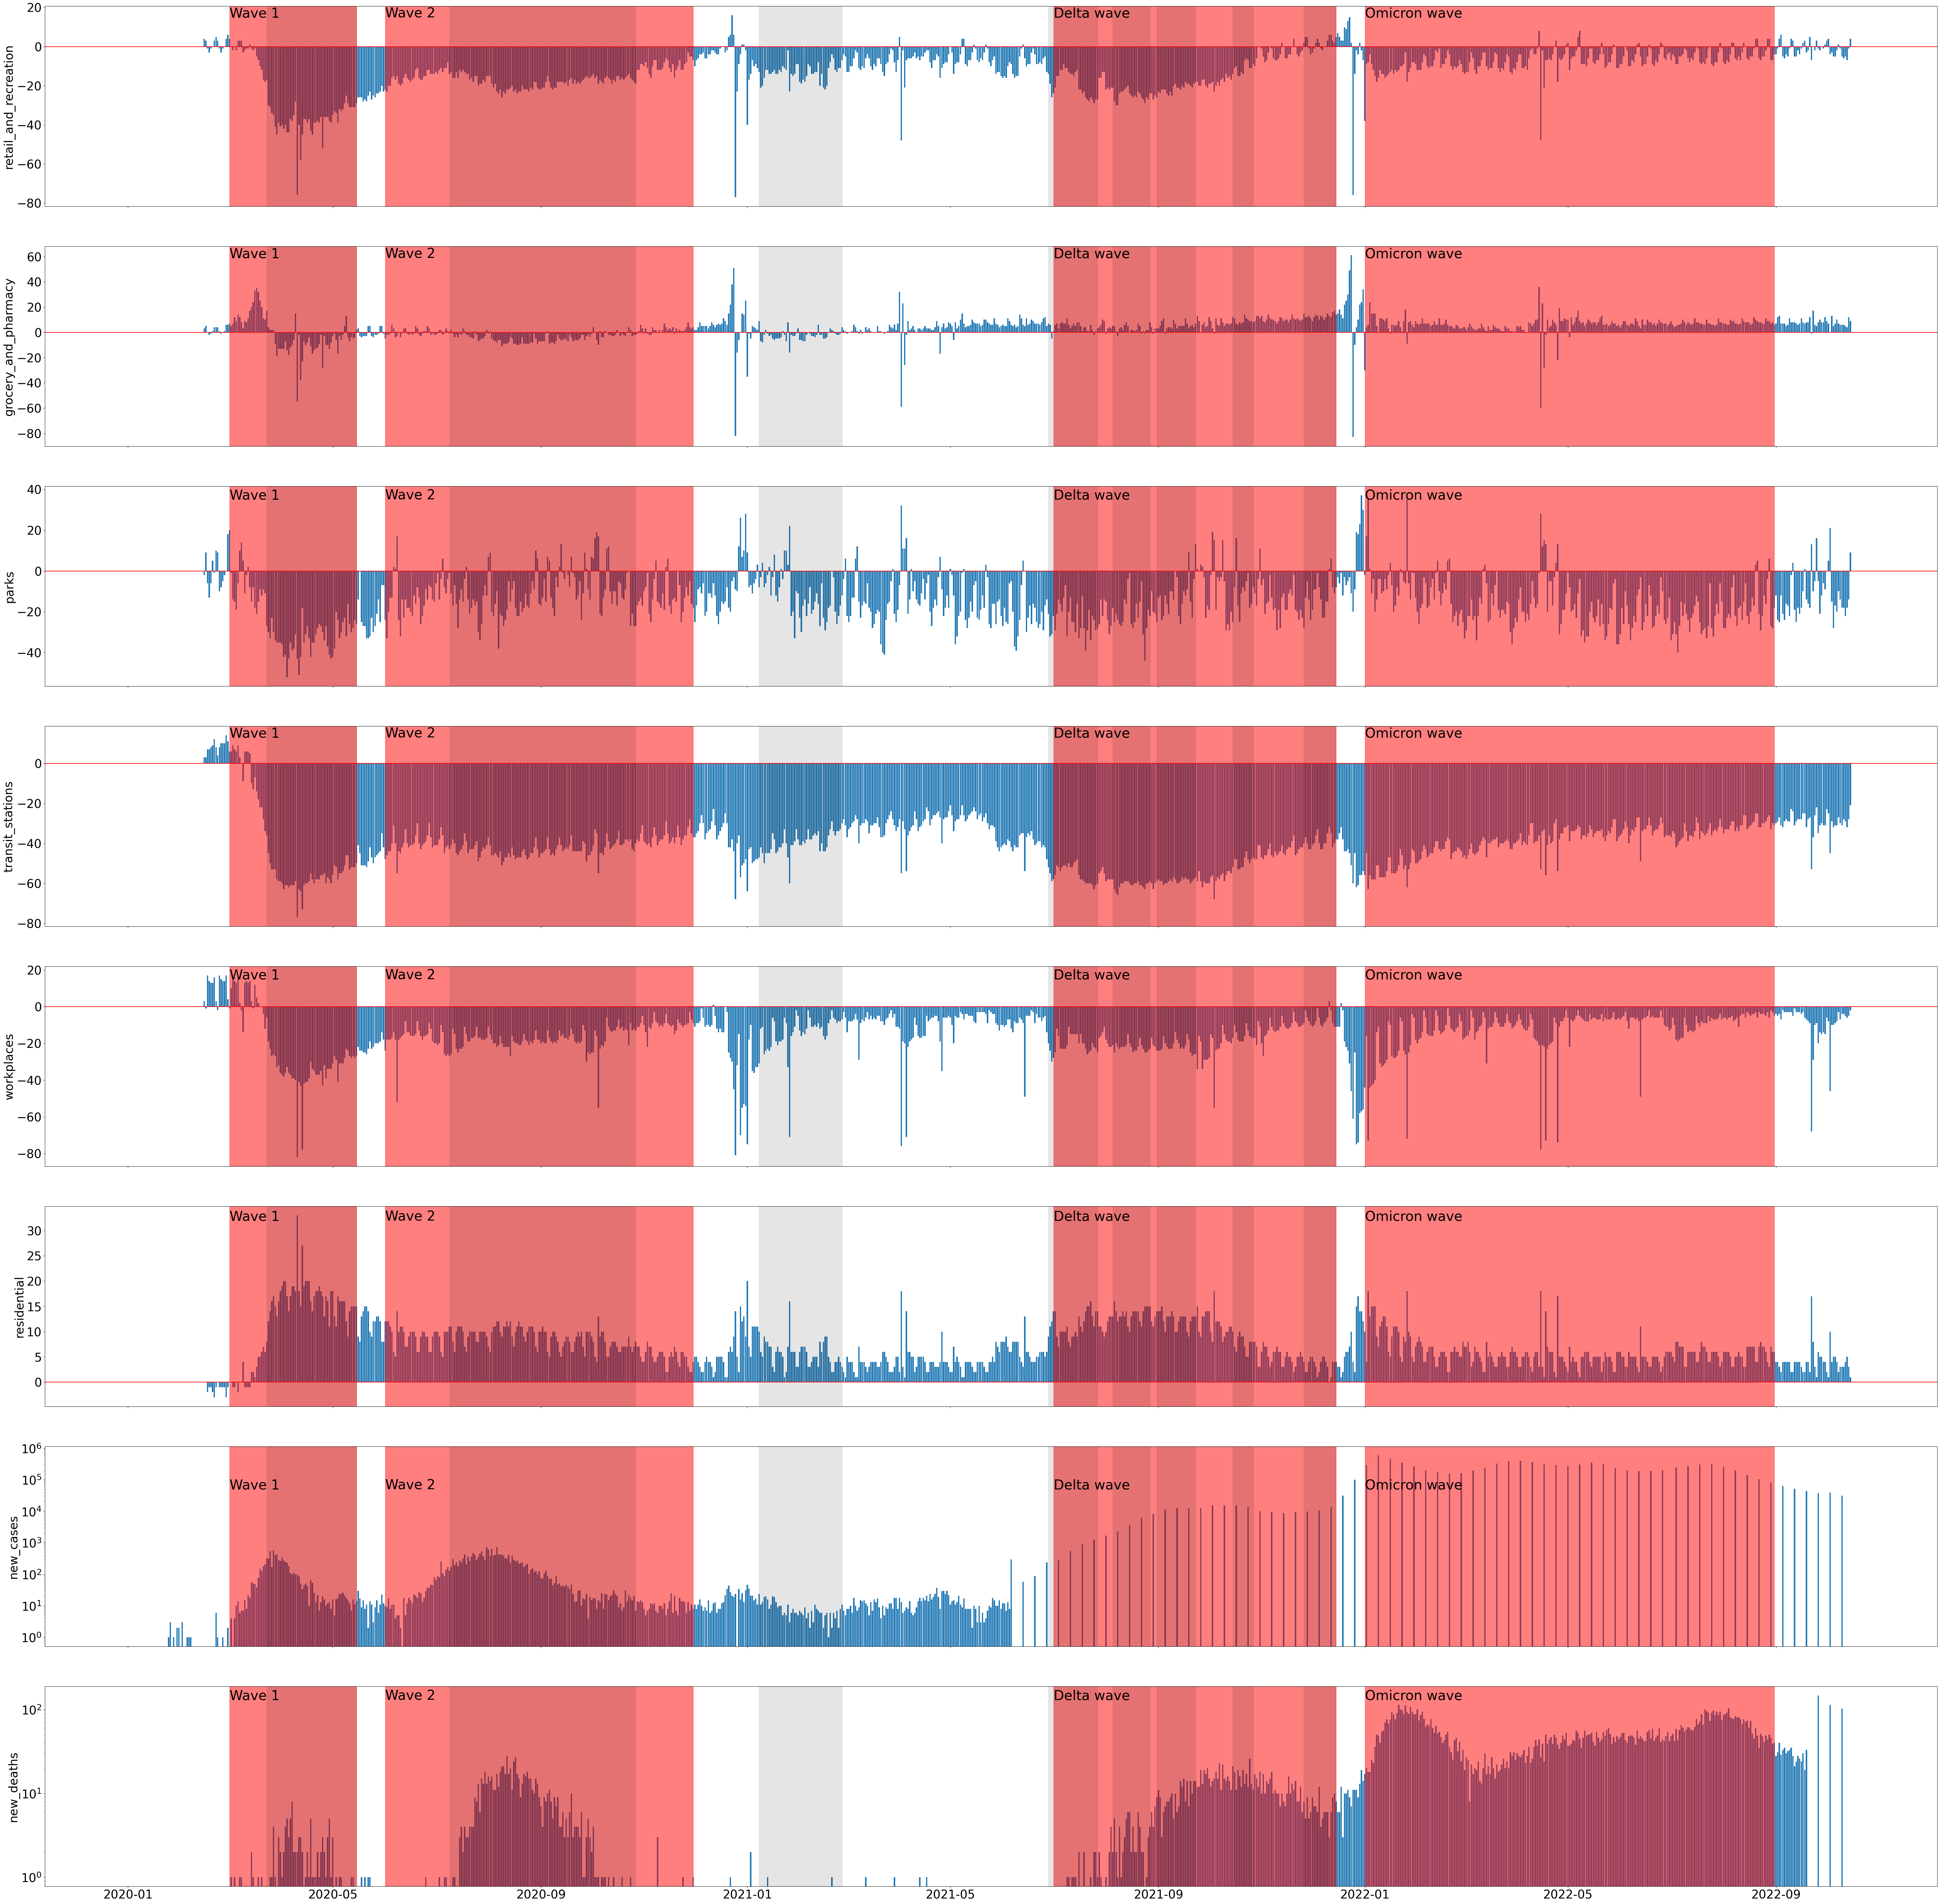

In [75]:
df_mobil_2020 = spark.read.csv('./datasets/2020_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2021 = spark.read.csv('./datasets/2021_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)
df_mobil_2022 = spark.read.csv('./datasets/2022_AU_Region_Mobility_Report.csv', header=True, inferSchema=True)

print(f'Dimension of mobility 2020: {df_mobil_2020.toPandas().shape}')
print(f'Dimension of mobility 2021: {df_mobil_2021.toPandas().shape}')
print(f'Dimension of mobility 2022: {df_mobil_2022.toPandas().shape}')

dfs_mobil_aus = df_mobil_2020.union(df_mobil_2021)\
                            .union(df_mobil_2022)\
                            .filter(col('sub_region_1').isNull())

dfs_mobil_aus.show(2)

pd_mobil_aus = dfs_mobil_aus.toPandas()



print(f'Dimension of mobility dataset combined (2020, 2021, 2022) Australia: {pd_mobil_aus.shape}')

# Printing Community mobility Australia
mpl.rcParams['font.size'] = 28
fig, axs = plt.subplots(8, 1, figsize=(80, 80), sharex=True, sharey=False)

axs[0].set_ylabel('retail_and_recreation')
axs[0].bar(pd_mobil_aus['date'], pd_mobil_aus['retail_and_recreation_percent_change_from_baseline'])

axs[1].set_ylabel('grocery_and_pharmacy')
axs[1].bar(pd_mobil_aus['date'], pd_mobil_aus['grocery_and_pharmacy_percent_change_from_baseline'])

axs[2].set_ylabel('parks')
axs[2].bar(pd_mobil_aus['date'], pd_mobil_aus['parks_percent_change_from_baseline'])

axs[3].set_ylabel('transit_stations')
axs[3].bar(pd_mobil_aus['date'], pd_mobil_aus['transit_stations_percent_change_from_baseline'])

axs[4].set_ylabel('workplaces')
axs[4].bar(pd_mobil_aus['date'], pd_mobil_aus['workplaces_percent_change_from_baseline'])

axs[5].set_ylabel('residential')
axs[5].bar(pd_mobil_aus['date'], pd_mobil_aus['residential_percent_change_from_baseline'])

axs[6].set_ylabel('new_cases')
axs[6].bar(dfs_cc_aus['date'], dfs_cc_aus['new_cases'])
axs[6].set_yscale('log')

axs[7].set_ylabel('new_deaths')
axs[7].bar(dfs_cc_aus['date'], dfs_cc_aus['new_deaths'])
axs[7].set_yscale('log')

for hoz_line in axs.flat:
    hoz_line.axhline(y=0, color='r', linestyle='-')

# Four waves of COVID-19 in Australia: Wave 1, Wave 2, Delta wave, Omicron wave
for idx, span in enumerate(axs.flat):
    axis_x_print = [15, 59, 35, 13, 15, 32, 50000 , 130]
    font_size = 32
    span.axvspan(datetime(2020, 3, 1), datetime(2020, 5, 15), color='red', alpha=0.5)
    span.text(datetime(2020, 3, 1), axis_x_print[idx], 'Wave 1', fontsize=font_size, color='black')
    span.axvspan(datetime(2020, 6, 1), datetime(2020, 11, 30), color='red', alpha=0.5)
    span.text(datetime(2020, 6, 1), axis_x_print[idx], 'Wave 2', fontsize=font_size, color='black')
    span.axvspan(datetime(2021, 7, 1), datetime(2021, 12, 15), color='red', alpha=0.5)
    span.text(datetime(2021, 7, 1), axis_x_print[idx], 'Delta wave', fontsize=font_size, color='black')
    span.axvspan(datetime(2022, 1, 1), datetime(2022, 8, 31), color='red', alpha=0.5)
    span.text(datetime(2022, 1, 1), axis_x_print[idx], 'Omicron wave', fontsize=font_size, color='black')

# Pricipal lockdowns of Australia
for span in axs.flat:
    span.axvspan(datetime(2020, 3, 23), datetime(2020, 5, 15), color='black', alpha=0.1)
    span.axvspan(datetime(2020, 7, 9), datetime(2020, 10, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 1, 8), datetime(2021, 2, 26), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 6, 28), datetime(2021, 7, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 8, 5), datetime(2021, 8, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 8, 31), datetime(2021, 9, 23), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 10, 15), datetime(2021, 10, 27), color='black', alpha=0.1)
    span.axvspan(datetime(2021, 11, 26), datetime(2021, 12, 15), color='black', alpha=0.1)

plt.show()

